In [1]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics

import warnings                               
warnings.filterwarnings('ignore')

In [47]:
df = pd.read_csv('./data/quiz2_history.csv')
y = df['revenue']
df

,revenue
0,404.879934
1,924.651221
2,2132.504201
3,2253.881184
4,4118.303117
...,...
115,86722.300084
116,78086.287180
117,62278.130177
118,48966.222205


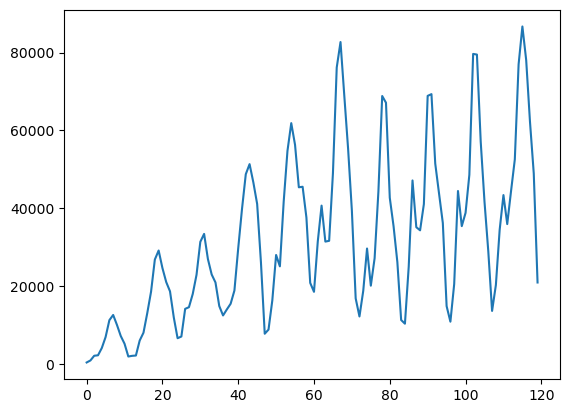

In [62]:
plt.plot(y)
plt.show()

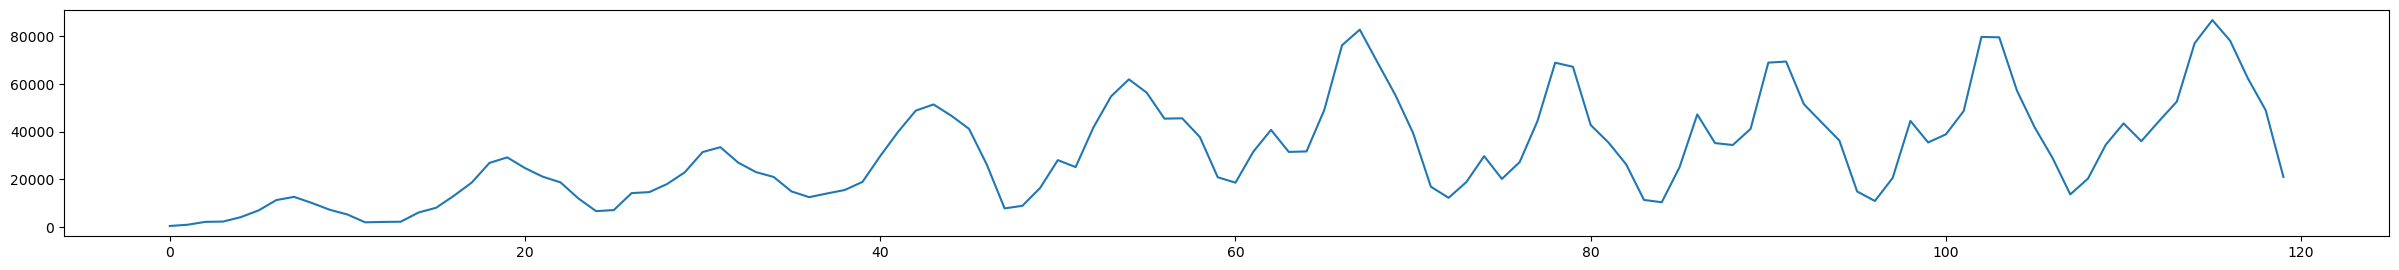

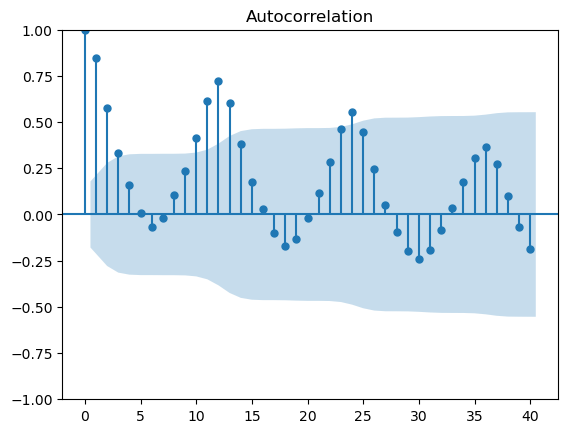

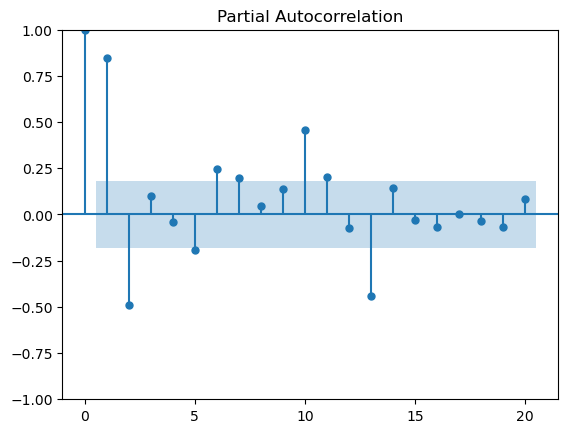

In [4]:
#visualize the data
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)

plt.plot(y)
plt.show()

plot_acf(y,lags=40)
plt.show()

plot_pacf(y,lags=20)
plt.show()

In [5]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [6]:
adf_test(y)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -2.101682
p-value                          0.243839
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [7]:
def plotMovingAverage(series, window, plot_actual=False, scale=1.96):

    rolling_mean = series.rolling(window=window,center=True).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    if plot_actual:
        plt.plot(series[window:], label="Actual values", color='#878a88', alpha=0.5)
        
    plt.legend(loc="upper left") 
    plt.grid(True)

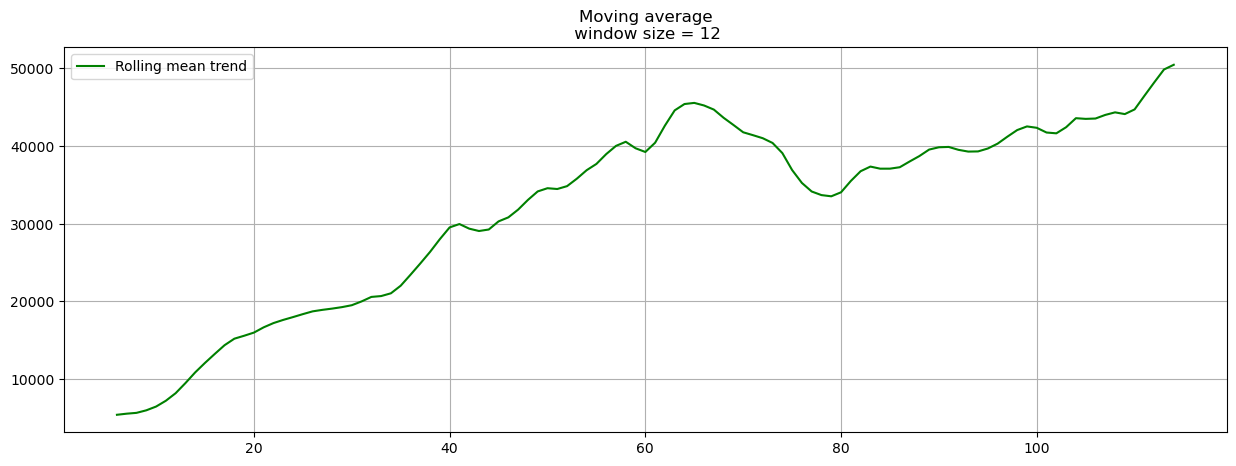

In [8]:
plotMovingAverage(y, 12)   

In [9]:
# define the function to difference the data ONCE
def diff(data, interval):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

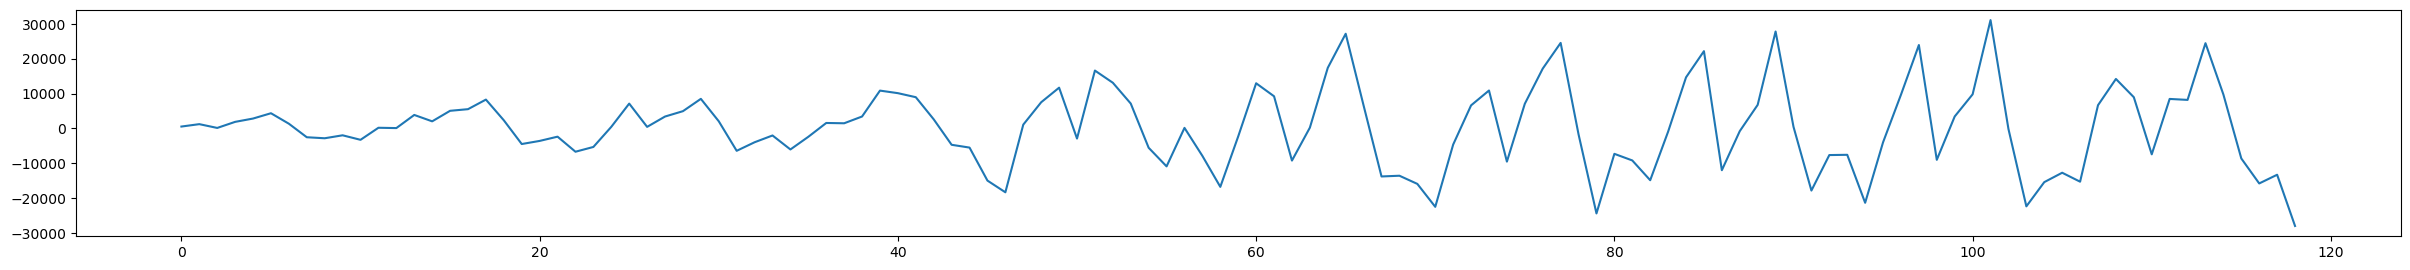

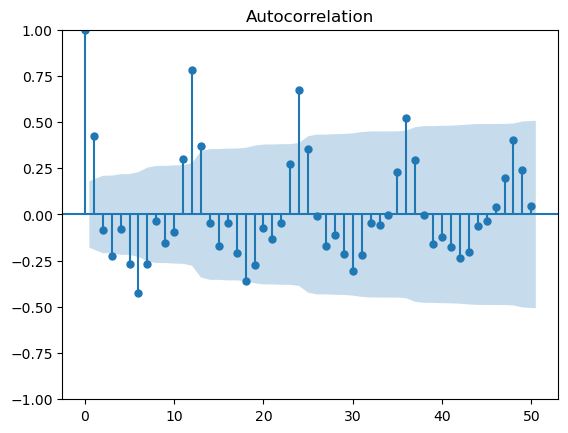

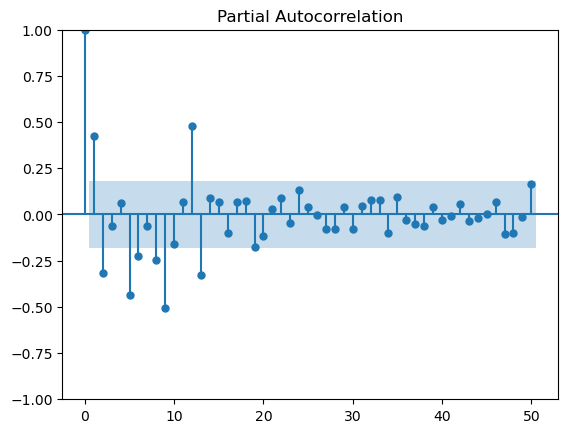

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.909059
p-value                          0.001969
#Lags Used                      13.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


In [33]:
D1=diff(y,1)
#visualize the differenced data
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)

plt.plot(D1)
plt.show()

plot_acf(D1,lags=50)
plt.show()

plot_pacf(D1,lags=50)
plt.show()

adf_test(D1)

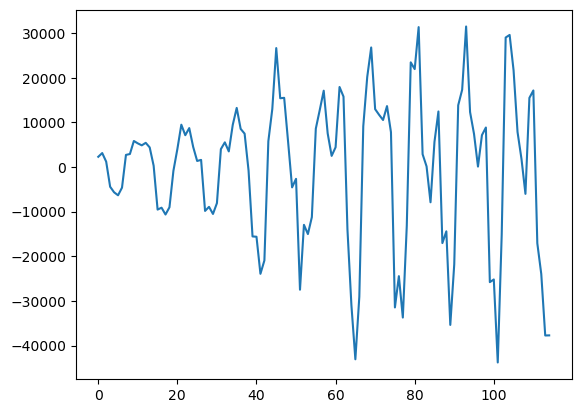

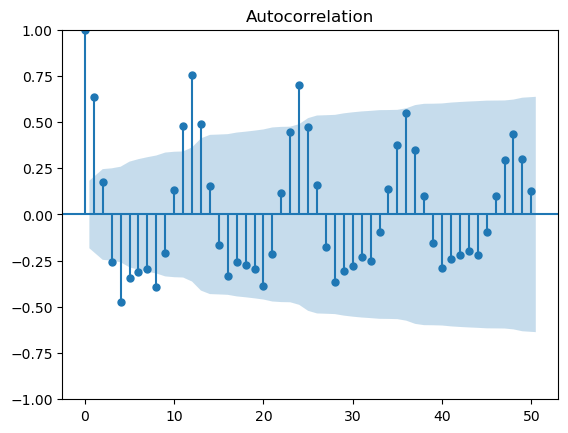

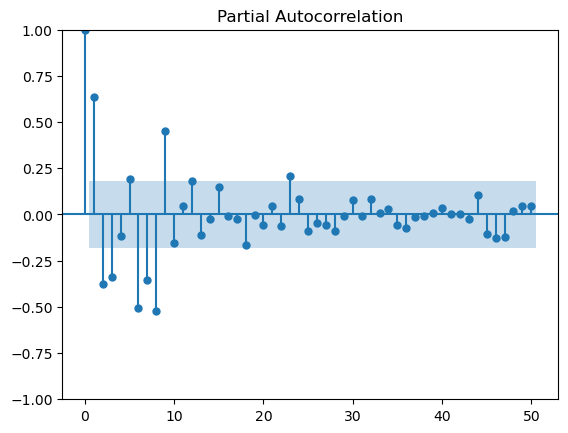

Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.737785e+00
p-value                        1.082025e-11
#Lags Used                     1.300000e+01
Number of Observations Used    1.010000e+02
Critical Value (1%)           -3.496818e+00
Critical Value (5%)           -2.890611e+00
Critical Value (10%)          -2.582277e+00
dtype: float64


In [39]:
deseason_df = diff(D1, 4)
plt.plot(deseason_df)
plot_acf(deseason_df ,lags=50) 
plot_pacf(deseason_df ,lags=50) 
plt.show()
adf_test(deseason_df)

In [43]:
def evaluate_models_cv(dataset, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    K=3
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p,d,q)
                            seasonal_order = (P,D,Q,m)
                            cfg = [(p,d,q), (P,D,Q,m)]
                            validation_size=12
                            train_size=len(dataset)-validation_size*K
                            rmse=0
                            for k in range(0,3):
                                train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+(k+1)*validation_size]
                                model = ARIMA(train, order=trend_order, seasonal_order=seasonal_order) #each step: rolling one step forward to update the train se
                                model_fit = model.fit()
                                predictions=model_fit.forecast(validation_size)
                                rmse = rmse+np.sqrt(skmetrics.mean_squared_error(test, predictions))
                            rmse_avg=rmse/3
                            result.append((cfg, rmse_avg))
                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('ARIMA%s RMSE=%.3f' % (cfg,rmse_avg))
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_rmse))

In [49]:
df['log_Y']=np.log(df['revenue'])
df_new=df['log_Y']

p=[0,1,2]
d=[1,2]
q=[0,1,2]
P=[0,1,2]
D=[1]
Q=[0,1,2]
m=4

evaluate_models_cv(df_new, p,d,q,P,D,Q,m)

ARIMA[(0, 1, 0), (0, 1, 0, 4)] RMSE=4.008
ARIMA[(0, 1, 0), (0, 1, 1, 4)] RMSE=0.917
ARIMA[(0, 1, 0), (0, 1, 2, 4)] RMSE=0.755
ARIMA[(0, 1, 0), (1, 1, 1, 4)] RMSE=0.747
ARIMA[(0, 1, 0), (2, 1, 0, 4)] RMSE=0.506
ARIMA[(0, 1, 0), (2, 1, 1, 4)] RMSE=0.500
ARIMA[(0, 1, 0), (2, 1, 2, 4)] RMSE=0.495
ARIMA[(1, 1, 2), (2, 1, 0, 4)] RMSE=0.413
ARIMA[(1, 1, 2), (2, 1, 1, 4)] RMSE=0.412
ARIMA[(1, 1, 2), (2, 1, 2, 4)] RMSE=0.390
Best SARIMA[(1, 1, 2), (2, 1, 2, 4)] RMSE=0.390


In [68]:
model = ARIMA(df_new,order=(1,1,2),seasonal_order=(2,1,2,4)).fit()
pred2 = model.predict(start=len(df_new),end=len(df_new)+11)
pred2 = np.exp(pred2) #convert back to orginal scale
pred2 = pd.DataFrame(pred2)
pred2

,predicted_mean
120,26964.606462
121,44200.395491
122,58894.592813
123,46523.161313
124,55467.426265
125,67002.815636
126,101503.501287
127,103659.176508
128,92289.724200
129,75771.168288


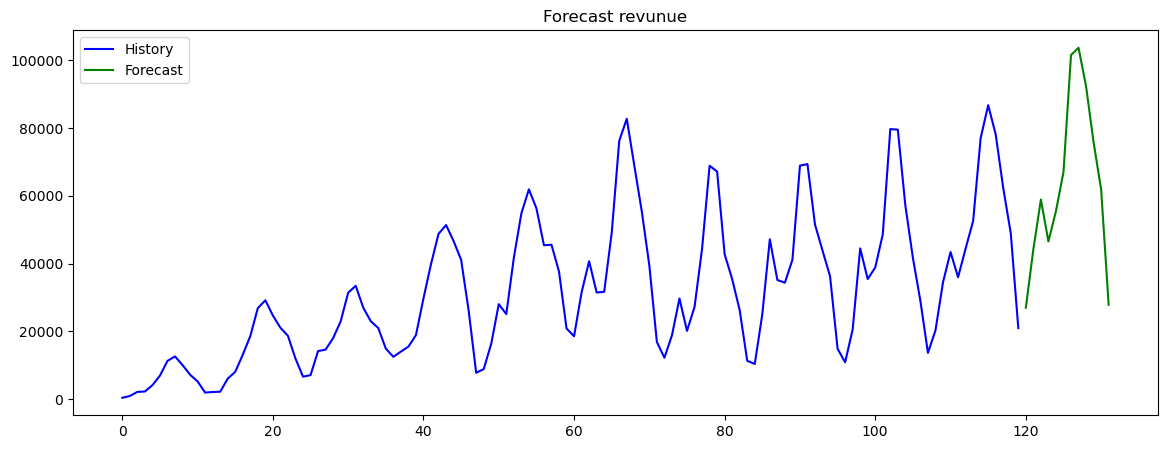

In [69]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
df.plot(kind='line', y='revenue', color='blue', label='History', ax=ax)
pred2.plot(kind='line', y='predicted_mean', color='green', label='Forecast', ax=ax)
plt.title('Forecast revunue')
plt.show()

In [70]:
pred2.columns = [['revenue_pred']]
pred2

,revenue_pred
120,26964.606462
121,44200.395491
122,58894.592813
123,46523.161313
124,55467.426265
125,67002.815636
126,101503.501287
127,103659.176508
128,92289.724200
129,75771.168288


In [71]:
pred2.to_csv('test_forecast.csv',index=False)

In [72]:
test = pd.read_csv('test_forecast.csv')
test

,revenue_pred
0,26964.606462
1,44200.395491
2,58894.592813
3,46523.161313
4,55467.426265
5,67002.815636
6,101503.501287
7,103659.176508
8,92289.724200
9,75771.168288
